# Progressive EDA (Kepler -> TESS -> K2)

> This notebook provides a progressive exploratory data analysis (EDA) and feature 
engineering pipeline for exoplanet catalogs from Kepler, TESS, and K2 missions. T
he workflow is designed to unify heterogeneous catalogs, derive physically meaningful features, 
and prepare the data for robust modeling and imputation.

**Main Goals:**

1. Load first lines of each catalog
2. Structural Profile (Types, missingness, amplitude, statistical)
3. Kepler: Key Distribution, correlations, disposition pattern
4. Preparate incremental comparation to TESS and K2

In [ ]:
# Let's start with the imports to look what we've got

import pandas as pd
import seaborn as sns, numpy as np, matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# Standard scientific Python stack is used. 
# KNNImputer and StandardScaler from sklearn are used for missing data imputation and normalization, respectively. 
# Seaborn is set for consistent plotting.


pd.set_option("display.max_columns",140) 
pd.set_option("display.width", 180)
sns.set_theme(context='notebook', style='whitegrid')
# Seaborn theme set for consistent, grid-based plots in notebook environment

In [2]:
# Our output directory to new dataset to modeling
OUTPUT_DIR = "./data/processed"

# Let's load each dataset
N_ROWS = 250

FILES = {
    'kepler': './data/raw/kepler_sat.csv',
    'tess': './data/raw/tess_sat.csv',
    'k2': './data/raw/k2_sat.csv'
}

## Canonical Feature Mapping

> Defines a minimal mapping dict: canonical_name -> per catalog source column + optional transform. Keep it extensible

In [ ]:
FEATURE_MAP = {
    #IDENTIFIERS / CLASSIFICATION
    "host_name": {
        'kepler': 'kepoi_name',
        'tess': 'hostname',
        'k2': 'hostname'
    },

    "planet_name": {
        'kepler': 'planet_name',
        'tess':'pl_name',
        'k2':'pl_name',
    },
    
    "disposition": {
        'kepler': 'koi_disposition',
        'tess':'disposition',
        'k2':'disposition',
    },

    # ORBITAL

    "orbital_period_days": {
        'kepler': 'koi_period',
        'tess':'pl_orbper',
        'k2':'pl_orbper',
    },

    "semi_major_axis_au":{
        'kepler': 'koi_sma',
        'tess':'pl_orbsmax',
        'k2':'pl_orbsmax',
    },

    "eccentricity": {
        'kepler': 'koi_eccen',
        'tess':'pl_orbeccen',
        'k2':'pl_orbeccen',
    },

    "inclination_deg":{
        'kepler': 'koi_incl',
        'tess':'pl_orbincl',
        'k2':'pl_orbincl',
    },

    # PLANET DIMENSIONS & MASS

    "planet_radius_re":{
        'kepler': 'koi_prad',
        'tess':'pl_rade',
        'k2':'pl_rade',
    },

    "planet_radius_rj":{
        'kepler': None,
        'tess':'pl_radj',
        'k2':'pl_radj',
    },

    "planet_mass_me":{
        'kepler': None,
        'tess':'pl_masse',
        'k2':'pl_masse',
    },

    "planet_mass_mj":{
        'kepler': None,
        'tess':'pl_massj',
        'k2':'pl_massj',
    },

    "planet_density_gcm3":{
        'kepler': None,
        'tess':'pl_dens',
        'k2':'pl_dens',
    },

    # TRANSIT GEOMETRY

    "transit_depth_ppm": {
        'kepler':'koi_depth',
        'tess':'pl_trandep',
        'k2':'pl_trandep',
    },

    "tansit_duration_hrs": {
        'kepler':'koi_duration',
        'tess':'pl_trandur',
        'k2':'pl_trandur',
    },

    "impact_parameter": {
        'kepler':'koi_impact',
        'tess':'pl_imppar',
        'k2':'pl_imppar',
    },

    "a_over_rstar": {
        'kepler':'koi_dor',
        'tess':'pl_ratdor',
        'k2':'pl_ratdor',
    },

    "radius_ratio": {
        'kepler':'koi_ror',
        'tess':'pl_ratror',
        'k2':'pl_ratror',
    },

    # STELLAR FUNDAMENTAL

    "stellar_teff_k": {
        'kepler': 'koi_steff',
        'tess':'st_teff',
        'k2':'st_teff',
    },
    
    "stellar_logg_cgs": {
        'kepler': 'koi_slogg',
        'tess':'st_logg',
        'k2':'st_logg',
    },
    
    "stellar_metallicity_dex": {
        'kepler': 'koi_smet',
        'tess':'st_met',
        'k2':'st_met',
    },
    
    "stellar_radius_rsun": {
        'kepler': 'koi_srad',
        'tess':'st_rad',
        'k2':'st_rad',
    },
    
    "stellar_mass_msun": {
        'kepler': 'koi_smass',
        'tess':'st_mass',
        'k2':'st_mass',
    },
    
    "stellar_density_cgs": {
        'kepler': 'koi_srho',
        'tess':'st_dens',
        'k2':'st_dens',
    },
    
    "stellar_luminosity_lsun": {
        'kepler': None,
        'tess':'st_lum',
        'k2':'st_lum',
    },
    
    "stellar_age_gyr": {
        'kepler': None,
        'tess':'st_age',
        'k2':'st_age',
    },
    
    "stellar__rot_period_days": {
        'kepler': None,
        'tess':'st_rotp',
        'k2':'st_rotp',
    },

    # IRRADIATION / PHOTOMETRY ESSENTIALS

    "planet_insolation_earth": {
        'kepler': 'koi_insol',
        'tess':'pl_insol',
        'k2':'pl_insol',
    },

    "planet_eq_temp_k": {
        'kepler': 'koi_teq',
        'tess':'pl_eqt',
        'k2':'pl_eqt',
    },

    # ASTROMETRY / PHOTOMETRY ESSENTIALS (SUBSET)

    "ra_deg": {
        'kepler': 'ra',
        'tess':'ra',
        'k2':'ra',
    },

    "dec_deg": {
        'kepler': 'dec',
        'tess':'dec',
        'k2':'dec',
    },

    "pm_ra_masyr": {
        'kepler': 'koi_pmra',
        'tess':'sy_pmra',
        'k2':'sy_pmra',
    },

    "pm_dec_masyr": {
        'kepler': 'koi_pmdec',
        'tess':'sy_pmdec',
        'k2':'sy_pmdec',
    },

    "parallax_mas": {
        'kepler': None,
        'tess':'sy_plx',
        'k2':'sy_plx',
    },

    "distance_pc": {
        'kepler': None,
        'tess':'sy_dist',
        'k2':'sy_dist',
    },

    # SIGNAL / QUALITY (PLACEHOLDER; KEPLER SPECIFIC SNR)

    "snr_model": {
        'kepler': 'koi_model_snr',
        'tess':None,
        'k2':None,
    },

    "snr_single_event": {
        'kepler': 'koi_max_sngle_ev',
        'tess':None,
        'k2':None,
    },

    "snr_multi_event": {
        'kepler': 'koi_max_mult_ev',
        'tess':None,
        'k2':None,
    },

    "depth_source_unit": {
        'kepler': 'koi_depth',
        'tess':'pl_trandep',
        'k2':'pl_trandep',
    }
}



**The FEATURE_MAP dictionary is the core of the schema unification process. 
It maps canonical feature names to their corresponding column names in each catalog, 
enabling seamless merging and processing of heterogeneous datasets!!**

In [4]:
CRITICAL_FEATURES = [
    "orbital_period_days", "planet_radius_re", "transit_depth_ppm",
    "stellar_teff_k", "stellar_radius_rsun", "stellar_mass_msun",
    "planet_insolation_earth", "planet_eq_temp_k"
]

**CRITICAL_FEATURES lists the most essential variables for exoplanet characterization 
and downstream modeling. These are prioritized for completeness analysis and imputation.**


## Loader & Notebook Helpers

> function to Load raw CSV (Skipping comment lines) and project to canonical schema and unify catalogs

In [5]:
def load_catalog(name: str, nrows=None) -> pd.DataFrame: 
    return pd.read_csv(FILES[name], comment="#", nrows=nrows, low_memory=False)

In [ ]:
##########################################- 32 -################################################
#
# The project_catalog function standardizes each catalog to the canonical schema, 
# handling missing columns and unit conversions (e.g., transit depth). 
# The unify function concatenates all catalogs into a single DataFrame for unified analysis.
#
##########################################- 32 -################################################

def project_catalog(df: pd.DataFrame, catalog: str) -> pd.DataFrame:
    out = {}
    for canon, mapping in FEATURE_MAP.items():
        col = mapping.get(catalog)
        if not col or col not in df.columns:
            out[canon] = pd.Series([pd.NA] * len(df))
            continue
        series = df[col]
        if canon == "transit_depth_ppm":
            vals = pd.to_numeric(series, errors="coerce")
            if vals.median(skipna=True) is not None and vals.median(skipna=True) < 0.01:
                series = vals * 1_000_000
            out[canon] = series
        else:
            out[canon] = series
    out_df = pd.DataFrame(out)
    out_df["source_catalog"] = catalog
    return out_df

In [7]:
def unify(nrows=None) -> pd.DataFrame:
    return pd.concat(
        [project_catalog(load_catalog(cat, nrows), cat) for cat in FILES],
        ignore_index=True
    )

## Build Unified Raw Dataset
Set NROWS=None for full load or reduce (e.g. 250) for faster

In [8]:
NROWS = None
unified_raw = unify(nrows = NROWS)
print("Unified shape:", unified_raw.shape)

Unified shape: (21224, 39)


/tmp/ipykernel_10506/936350926.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(


In [9]:
unified_raw.head(3)

,host_name,planet_name,disposition,orbital_period_days,semi_major_axis_au,eccentricity,inclination_deg,planet_radius_re,planet_radius_rj,planet_mass_me,planet_mass_mj,planet_density_gcm3,transit_depth_ppm,tansit_duration_hrs,impact_parameter,a_over_rstar,radius_ratio,stellar_teff_k,stellar_logg_cgs,stellar_metallicity_dex,stellar_radius_rsun,stellar_mass_msun,stellar_density_cgs,stellar_luminosity_lsun,stellar_age_gyr,stellar__rot_period_days,planet_insolation_earth,planet_eq_temp_k,ra_deg,dec_deg,pm_ra_masyr,pm_dec_masyr,parallax_mas,distance_pc,snr_model,snr_single_event,snr_multi_event,depth_source_unit,source_catalog
0,K00752.01,<NA>,CONFIRMED,9.488036,0.0853,0.0,89.66,2.26,NaN,NaN,NaN,NaN,615.8,2.9575,0.146,24.81,0.022344,5455.0,4.467,0.14,0.927,0.919,3.20796,NaN,NaN,NaN,93.59,793.0,291.93423,48.141651,NaN,NaN,NaN,NaN,35.8,5.135849,28.470820,615.8,kepler
1,K00752.02,<NA>,CONFIRMED,54.418383,0.2734,0.0,89.57,2.83,NaN,NaN,NaN,NaN,874.8,4.5070,0.586,77.90,0.027954,5455.0,4.467,0.14,0.927,0.919,3.02368,NaN,NaN,NaN,9.11,443.0,291.93423,48.141651,NaN,NaN,NaN,NaN,25.8,7.027669,20.109507,874.8,kepler
2,K00753.01,<NA>,CANDIDATE,19.899140,0.1419,0.0,88.96,14.60,NaN,NaN,NaN,NaN,10829.0,1.7822,0.969,53.50,0.154046,5853.0,4.544,-0.18,0.868,0.961,7.29555,NaN,NaN,NaN,39.30,638.0,297.00482,48.134129,NaN,NaN,NaN,NaN,76.3,37.159767,187.449100,10829.0,kepler


In [10]:
# COMPLETENESS FOR CRITICAL FEATUREs
total = len(unified_raw)
rows = []
for c in CRITICAL_FEATURES:
    nn = unified_raw[c].notna().sum()
    rows.append({
        "feature": c,
        "non_null": int(nn),
        "pct": round(nn/total*100, 2)
    })

completeness_df = pd.DataFrame(rows).sort_values("pct", ascending=False)
completeness_df

,feature,non_null,pct
0,orbital_period_days,21051,99.18
4,stellar_radius_rsun,20210,95.22
3,stellar_teff_k,19574,92.23
1,planet_radius_re,19514,91.94
2,transit_depth_ppm,18943,89.25
7,planet_eq_temp_k,17392,81.94
6,planet_insolation_earth,17353,81.76
5,stellar_mass_msun,11290,53.19


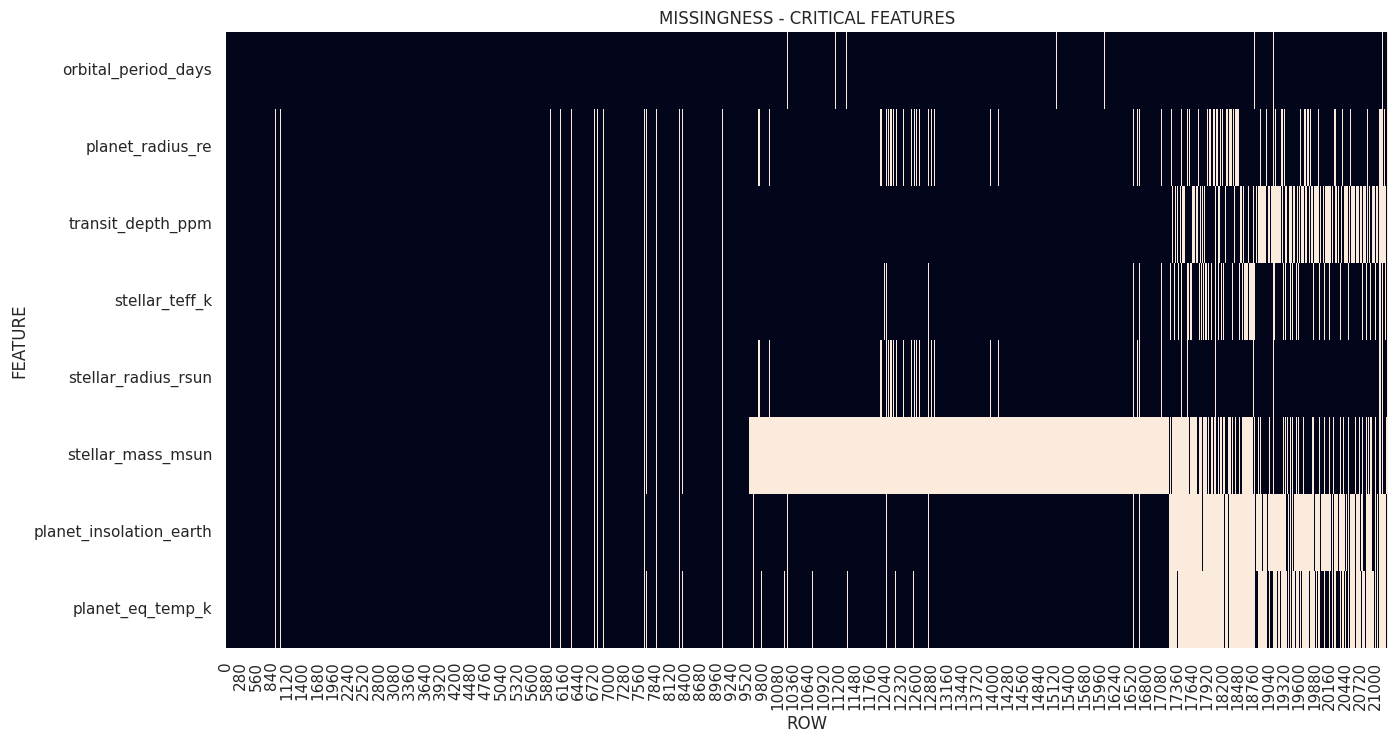

In [11]:
# MISSINGNESS HEATMAP (CRITICAL)
plt.figure(figsize=(15,8))
sns.heatmap(unified_raw[CRITICAL_FEATURES].isna().T, cbar=False)
plt.title("MISSINGNESS - CRITICAL FEATURES")
plt.ylabel("FEATURE")
plt.xlabel("ROW")
plt.show()

# DERIVED FEATURES

> Add physics-based enrichments: gravity, luminosity estimate, semi-major axis estimate, insolation & equilibrium temp recalculated, density, Teff bins,
> interactions, radius ratio fallback, depth residual.

In [12]:
# Some constants defined on physics

G = 6.67430e-11 # m^3 kg^-1 s^-2
M_EARTH = 5.9722e24 # kg
R_EARTH = 6.371e6 # m
M_JUP = 1.89813e27 # kg
R_JUP = 6.9911e7 # m 
SIGMA_SB = 5.670374419e-8 # W m^-2 K^-4
L_SUN = 3.828e26 # W
R_SUN = 6.957e8 # m
TEFF_SUN = 5772.0
AU_M = 1.495978707e11

In [23]:
################################### | | | #################################### | | | ####################################
# Derivated features that we can implement:
#
# Planet Surface Gravity in m/s²: g = G * M / R² (Earth/Jupiter conversion handled :) )
#
# Stellar Luminosity in AU: if luminosity is missing, estimate via (R/Rsun)^2 * (Teff/5772 K) ^ 4
#
# Semi Major Axis of Planetary Orbit in AU, if 'semi_major_axis_au' missing estimate via Kepler's third law (P in days, Mstar in Msun): a(AU) = ( (P/365.25)^2 * Mstar) ^(1/3) -> This represents
# the mean of distance between planet and your star in an eliptic orbit
#
# Incident Flux Recalculatade: Recompute insolation using luminosity and a (S_earth)
#
# Equilibrium Temperature: Theoric temp if planet was a black body in radioactive equilibrium: Teq = Teff * sqrt (R * / (2a)) * ( 1 - A) ^ (1/4) with A=0 (Zero albedo) Planet absorving 100% of light
#
# Planetary Density: Relation between mass and volume
#
#################################### | | | #################################### | | | ####################################

def compute_derived(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    def num(col):
        return pd.to_numeric(d[col], errors='coerce') if col in d.columns else pd.Series(np.nan, index=d.index)

    m_me = num("planet_mass_me")
    m_mj = num("planet_mass_mj")
    r_re = num("planet_radius_re")
    r_rj = num("planet_radius_rj")

    mass_kg = np.where(~m_me.isna(), m_me * M_EARTH, np.where(~m_mj.isna(), m_mj * M_JUP, np.nan))
    radius_m = np.where(~r_re.isna(), r_re * R_EARTH, np.where(~r_rj.isna(), r_rj * R_JUP, np.nan))

    d['planet_surface_gravity_ms2'] = G * mass_kg / np.where(radius_m > 0, radius_m ** 2, np.nan)

    teff = num('stellar_teff_k')
    rstar = num('stellar_radius_rsun')
    d['stellar_luminosity_lsun_est'] = (rstar ** 2) * (teff/TEFF_SUN) ** 4

    period = num('orbital_period_days')
    mstar = num('stellar_mass_msun')
    a_est = ((period / 365.25) ** 2 *  mstar) ** (1/3)
    have_a = num('semi_major_axis_au')
    d['semi_major_axis_au_est'] = np.where(have_a.notna(), have_a, a_est)

    a_use = pd.to_numeric(d['semi_major_axis_au_est'], errors='coerce')
    flux_recalc = np.where(a_use > 0, d['stellar_luminosity_lsun_est'] / (a_use ** 2), np.nan)
    d['incident_flux_recalc'] = flux_recalc

    orig_flux = num('planet_insolation_earth')
    d['planet_insolation_earth_combined'] = np.where(orig_flux.notna(), orig_flux, flux_recalc)

    a_m = a_use * AU_M
    teq_recalc = teff * np.sqrt(np.where(a_m > 0, (rstar * R_SUN) / (2 * a_m), np.nan))
    d['equilibrium_temp_recalc_k'] = teq_recalc

    orig_teq = num('planet_eq_temp_k')
    d['planet_eq_temp_k_combined'] = np.where(orig_teq.notna(), orig_teq, teq_recalc)

    volume_m3 = (4 / 3) * np.pi * np.where(radius_m > 0, radius_m ** 3, np.nan)
    dens_calc = mass_kg / volume_m3 / 1000
    dens_obs = num('planet_density_gcm3')
    d['planet_density_calc_gcm3'] = dens_calc
    d['planet_density_final_gcm3'] = np.where(dens_obs.notna(), dens_obs, dens_calc)

    def teff_bin(x):
        if pd.isna(x):
            return 'unk'
        if x < 4000:
            return 'cool'
        if x < 6000:
            return 'solar'
        if x < 7500:
            return 'hot'
        return 'very_hot'
        
    d['stellar_teff_bin'] = teff.apply(teff_bin)

    d['log_orbital_period'] = np.log10(period.where(period > 0))
    
    d['period_mass_interaction'] = period * mstar

    if 'radius_ratio' not in d.columns:
        d['radius_ratio'] = pd.NA

    rr_existing = pd.to_numeric(d['radius_ratio'], errors='coerce')
    rr_derived = np.where((r_re.notna()) & (rstar.notna()) & (rstar > 0), r_re / (rstar * 109.1), np.nan)
    d['radius_ratio_combined'] = np.where(rr_existing.notna(), rr_existing, rr_derived)

    depth_ppm = pd.to_numeric(d['transit_depth_ppm'], errors='coerce')
    d['depth_ratio_residual'] = (depth_ppm / 1e6) - (d['radius_ratio_combined'] ** 2)
    
    return d

In [25]:
derived = compute_derived(unified_raw)
derived.shape

(21224, 53)

In [28]:
new_cols = [c for c in derived.columns if c not in unified_raw.columns]
print(f'New derived columns (First 15): {new_cols[:15]} \n\nTotal={len(new_cols)}')

New derived columns (First 15): ['planet_surface_gravity_ms2', 'stellar_luminosity_lsun_est', 'semi_major_axis_au_est', 'incident_flux_recalc', 'planet_insolation_earth_combined', 'equilibrium_temp_recalc_k', 'planet_eq_temp_k_combined', 'planet_density_calc_gcm3', 'planet_density_final_gcm3', 'stellar_teff_bin', 'log_orbital_period', 'period_mass_interaction', 'radius_ratio_combined', 'depth_ratio_residual'] 

Total=14


## Heavy-Tail Variable Distributions (Pre-Imputation)

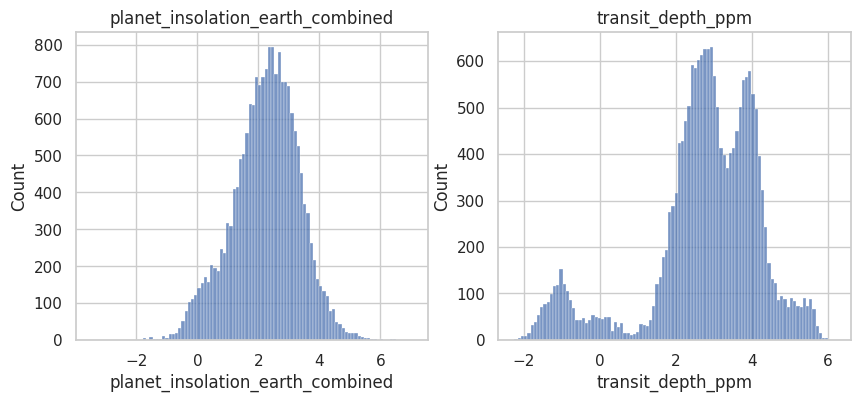

In [36]:
heavy = ["planet_insolation_earth_combined", "transit_depth_ppm"]

fig, axes = plt.subplots(1, len(heavy), figsize=(10,4))

for ax, feat in zip(axes, heavy):
    vals = pd.to_numeric(derived[feat], errors='coerce')
    sns.histplot(np.log10(vals[vals > 0]), ax=ax, bins=100)
    ax.set_title(feat)
plt.show()

## KNN Imputation
> Similarity features: stellar atmosphere & structure. Targets include combined flux/temp and key planetary indicators

In [37]:
SIMILARITY_FEATURES = [
    'stellar_teff_k', 'stellar_logg_cgs', 'stellar_metallicity_dex',
    'stellar_radius_rsun', 'stellar_mass_msun'
]

IMPUTE_TARGETS = [
    'planet_eq_temp_k_combined', 'planet_insolation_earth_combined',
    'stellar_mass_msun', 'stellar_radius_rsun', 'stellar_teff_k',
    'planet_radius_re', 'transit_depth_ppm'
]

In [48]:
def knn_impute(df: pd.DataFrame, n_neighbors=7):
    work = df.copy()

    # Guarantee columns
    for c in SIMILARITY_FEATURES + IMPUTE_TARGETS:
        if c not in work.columns:
            work[c] = np.nan

    # Numeric Base
    cols = list(dict.fromkeys(SIMILARITY_FEATURES + IMPUTE_TARGETS))  # preserva ordem sem duplicar
    base = work[cols].apply(pd.to_numeric, errors='coerce')

    # Scaling
    scaler = StandardScaler()
    scaled = scaler.fit_transform(base)

    # Imputation
    imputer = KNNImputer(n_neighbors=n_neighbors, weights='distance')
    imputed_scaled = imputer.fit_transform(scaled)
    imputed = scaler.inverse_transform(imputed_scaled)
    imputed_df = pd.DataFrame(imputed, columns=cols, index=work.index)

    # Changing values
    summary = []
    for col in IMPUTE_TARGETS:
        orig = base[col]
        new = imputed_df[col]
        filled = orig.isna() & new.notna()

        work[f'{col}_imp'] = orig.combine_first(new)
        work[f'{col}_was_imputed'] = filled

        summary.append({
            'column': col,
            'filled_count': int(filled.sum()),
            'orig_non_null': int(orig.notna().sum()),
            'final_non_null': int(work[col].notna().sum())
        })

    return work, pd.DataFrame(summary).sort_values("filled_count", ascending=False)


In [49]:
imputed, impute_summary = knn_impute(derived, n_neighbors = 7)

In [50]:
imputed.shape

(21224, 67)

In [51]:
impute_summary.head()

,column,filled_count,orig_non_null,final_non_null
2,stellar_mass_msun,9934,11290,11290
0,planet_eq_temp_k_combined,2463,18761,18761
1,planet_insolation_earth_combined,2302,18922,18922
6,transit_depth_ppm,2281,18943,18943
5,planet_radius_re,1710,19514,19514


In [52]:
from scipy.stats import ks_2samp

drift = []
for col in IMPUTE_TARGETS:
    orig = pd.to_numeric(derived[col], errors='coerce').dropna()
    final = pd.to_numeric(imputed[f'{col}_imp'], errors='coerce').dropna()
    if len(orig) > 30 and len(final) > 30:
        stat, p = ks_2samp(
            orig.sample(min(500, len(orig)), random_state = 32),
            final.sample(min(500, len(final)), random_state = 32)
        )
    else:
        stat, p = np.nan, np.nan
    
    drift.append(
        {
            'column': col,
            'ks_stat': stat,
            'ks_pvalue': p
        })

pd.DataFrame(drift).sort_values('ks_stat', ascending=False)

,column,ks_stat,ks_pvalue
2,stellar_mass_msun,0.196,8.191314e-09
5,planet_radius_re,0.092,2.899596e-02
3,stellar_radius_rsun,0.092,2.899596e-02
0,planet_eq_temp_k_combined,0.060,3.293581e-01
4,stellar_teff_k,0.058,3.699050e-01
1,planet_insolation_earth_combined,0.042,7.704365e-01
6,transit_depth_ppm,0.042,7.704365e-01


In [ ]:
################################### | | | #################################### | | | ####################################
# stellar_mass_msun -> Drastic changing (Probably 9k values added by imputation)
#
# planet_radius_re and stellar_radius_rsun -> Moderated changing but statiscally significative, less values imputed
#
# planet_insolation_earth_combined and transit_depth_ppm -> Almost identical between and after imputation, THAT's GREAT
#
#################################### | | | #################################### | | | ####################################


In [55]:
raw_path = 'data/processed/exoplanets_unified_raw.csv'
derived_path = 'data/processed/exoplanets_unified_derived.csv'
imputed_path = 'data/processed/exoplanets_unified_derived_imputed.csv'

unified_raw.to_csv(raw_path, index=False)
derived.to_csv(derived_path, index=False)
imputed.to_csv(imputed_path, index=False)